<a href="https://colab.research.google.com/github/anetanowak55/skin-cancer-classification/blob/main/skin_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Importy

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install tensorflowjs
!pip show tensorflow
!pip show keras
!python -V

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 40 kB 5.0 MB/s 
     |████████████████████████████████| 16.2 MB 80.2 MB/s 
     |████████████████████████████████| 197 kB 103.7 MB/s 
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 154 kB 98.5 MB/s 
     |████████████████████████████████| 8.3 MB 91.7 MB/s 
     |████████████████████████████████| 237 kB 106.2 MB/s 
     |████████████████████████████████| 66 kB 5.8 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
     |████████████████████████████████| 439 kB 88.2 MB/s 
     |████████████████████████████████| 6.0 MB 62.6 MB/s 
     |████████████████████████████████| 1.7 MB 91.8 MB/s 
     |████████████████████████████████| 85 kB 5.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimat

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflowjs as tfjs

#1. Konfiguracja

In [ ]:
SEED=123
np.random.seed(SEED)

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
base_path = "drive/MyDrive/Colab Notebooks/"
path_train_csv = "train.csv"
path_test_csv = "test.csv"
path_train_img = base_path + "img/train"
path_test_img = base_path + "jpeg/test"
checkpoint_path = base_path + "checkpoint/"
tfjs_target_dir = base_path + "/tfjs"

In [ ]:
CONFIG = dict(
    # Preprocessing
    validation = 0.25,
    target_size = (224,224),
    input_shape = (224, 224, 3),
    frac = 0.1, # fraction of train dataset to use

    # Training
    epochs = 5,   # 5; 10; 20; 100
    verbose = 1,    # 0; 1
    workers = 4,    # 1; 2; 3; 4
    optimizer = 'adam', # 'SGD', 'RMSprop', 'adam'
    RANDOM_STATE = 123,
    loss = 'binary_crossentropy', # focal loss

    # Postprocessing
    label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;
)

#2. Wczytanie i eksploracja danych

In [ ]:
train_df = pd.read_csv(base_path + path_train_csv)
train_df['image_filename'] = train_df['image_name'].astype(str) + ".jpg"
train_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,image_filename
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,ISIC_2637011.jpg
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,ISIC_0015719.jpg
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,ISIC_0052212.jpg
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,ISIC_0068279.jpg
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,ISIC_0074268.jpg
...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,ISIC_9999134.jpg
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,ISIC_9999320.jpg
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,ISIC_9999515.jpg
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,ISIC_9999666.jpg


In [ ]:
train_df.groupby('benign_malignant').size()

benign_malignant
benign       32542
malignant      584
dtype: int64

In [ ]:
# # Create a dataset with equal number of malignant and benign cases.

# b, m = train_df.groupby('benign_malignant')
# b[1].drop(b[1].index[584:], inplace=True)
# b[1]
# train_df=pd.concat([m[1], b[1]])
# train_df.groupby('benign_malignant').size()

#3. Zapisanie obrazów w odpowiedniej strukturze katalogów

In [ ]:
# b, m = train_df.groupby('benign_malignant')
# b = b[1]
# m = m[1]

In [ ]:
# path = base_path + '/img/malignant/'
# for item in m['image_filename']:
#   img = Image.open(path_train_img+"/"+item)
#   img.save(path+item)

In [ ]:
# Create a train_df that uses % of each label (benign and malignant). Used for quicker adjusting model config.

# train_df = train_df.groupby('benign_malignant', group_keys=False).apply(lambda x: x.sample(frac=CONFIG.get('frac')))
# train_df.groupby('benign_malignant').size()

In [ ]:
test_df = pd.read_csv(base_path + path_test_csv)
test_df['image_filename'] = test_df['image_name'].astype(str) + ".jpg"

#4. Przygotowanie zbiorów danych treningowych i testowych

In [ ]:
# # making sure the proportion of classes is equal in train and validation set
# train_train, train_valid = train_test_split(train_df, test_size=CONFIG.get("validation"), stratify=train_df['benign_malignant'])
# train_df_stratified = pd.concat([train_train, train_valid])
# train_df_stratified

In [ ]:
# # ref: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

# datagen = ImageDataGenerator(validation_split=CONFIG.get("validation")) # todo image augmentation??

# train_generator = datagen.flow_from_dataframe(
#   dataframe = train_train,
#   directory = path_train_img,
#   x_col = "image_filename",
#   y_col = "benign_malignant",
#   subset="training",
#   batch_size = 32,
#   seed = SEED,
#   shuffle = False,
#   class_mode = "categorical",
#   target_size = CONFIG.get("target_size"))

# valid_generator = datagen.flow_from_dataframe(
#   dataframe = train_valid,
#   directory = path_train_img,
#   x_col = "image_filename",
#   y_col = "benign_malignant",
#   subset="validation",
#   batch_size = 32,
#   seed = SEED,
#   shuffle = False,
#   class_mode = "categorical",
#   target_size = CONFIG.get("target_size"))

# test_datagen = ImageDataGenerator()

# test_generator = valid_generator = datagen.flow_from_dataframe(
#   dataframe = test_df,
#   directory = path_test_img,
#   x_col = "image_filename",
#   y_col = None,
#   subset = "validation",
#   batch_size = 32,
#   seed = SEED,
#   shuffle = False,
#   class_mode = None,
#   target_size = CONFIG.get("target_size"))

In [ ]:
# train_dir = base_path + '/img'
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=0.3, image_size=(224,224), subset="training", seed=SEED)
# valid_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=0.3, image_size=(224,224), subset="validation",seed=SEED)

# class_names = train_ds.class_names
# num_classes = len(class_names)
# print('\n{} classes:\n{}'.format(num_classes,class_names))

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(path_train_img,
                                                    subset='training', 
                                                    target_size=CONFIG.get("target_size"),
                                                    batch_size = 16,
                                                    class_mode='categorical',
                                                    )

valid_generator = train_datagen.flow_from_directory(path_train_img,
                                                     subset='validation', 
                                                     target_size=CONFIG.get("target_size"),
                                                     batch_size = 16,
                                                     class_mode='categorical'
                                                     ) 

class_names = train_generator.class_indices
num_classes = len(class_names)
print('\n{} classes:\n{}'.format(num_classes,class_names))

Found 818 images belonging to 2 classes.
Found 350 images belonging to 2 classes.

2 classes:
{'benign': 0, 'malignant': 1}


#5. Deklaracja funkcji focal_loss

Focal loss - function that addresses class imbalance during training in tasks like object detection

Ref: https://github.com/mkocabas/focal-loss-keras

In [ ]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

#6. Przygotowanie modelu

In [ ]:
model_ResNet50 = tf.keras.Sequential([
     tf.keras.applications.ResNet50(
        input_shape = CONFIG.get("input_shape"),
        weights = 'imagenet', # one of None (random initialization), 
                              # 'imagenet' (pre-training on ImageNet) - default,
                              # or the path to the weights file to be loaded
        include_top = False # include the fully-connected layer at the top of the network
    ),
    
    GlobalAveragePooling2D(),
    
    Dense(num_classes, activation='softmax')
])
    
model_ResNet50.compile(
    optimizer = CONFIG.get("optimizer"),
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CONFIG.get("label_smooth_fac")),
    loss = CONFIG.get('loss'), #[focal_loss(alpha=.25, gamma=2)],
    metrics = ['accuracy']
)

model_ResNet50.summary()


94765736/94765736 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# We reduce significantly number of trainable parameters by freezing certain layers, excluding from training, i.e. their weights will never be updated

# freeze the first 1 layer

model_ResNet50.layers[0].trainable = False
#for layer in model_ResNet50.layers[:1]:
#    layer.trainable = False
model_ResNet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


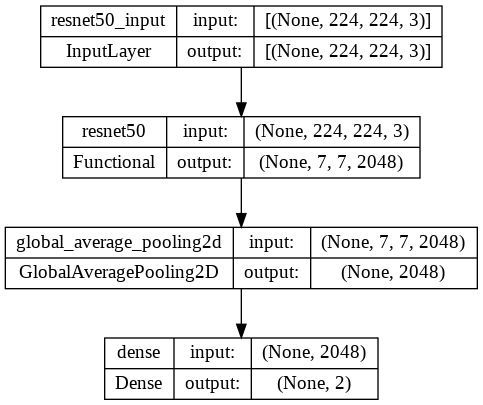

In [ ]:
# Plot model scheme with TF/Keras plot_model function
plot_model(model_ResNet50, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#7. Trenowanie modelu

In [ ]:
# ref: https://keras.io/api/callbacks/early_stopping/
cb_early_stopper = EarlyStopping(monitor = 'loss', patience = 1)

# ref: https://keras.io/api/callbacks/model_checkpoint/
cb_checkpointer  = ModelCheckpoint(filepath = checkpoint_path+'ResNet50-{epoch:02d}.hdf5',
                                   monitor = 'loss', 
                                   verbose = 1,
                                   save_best_only = True,
                                   mode = 'min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

In [ ]:
history = model_ResNet50.fit(train_generator, 
                             epochs=CONFIG.get("epochs"), 
                             workers=CONFIG.get("workers"),
                             validation_data=valid_generator,
                             callbacks = callbacks_list 
                            )

Epoch 1/5
52/52 [==============================] - ETA: 0s - loss: 0.7808 - accuracy: 0.6614
Epoch 1: loss improved from inf to 0.78075, saving model to drive/MyDrive/Colab Notebooks/checkpoint/ResNet50-01.hdf5
52/52 [==============================] - 260s 4s/step - loss: 0.7808 - accuracy: 0.6614 - val_loss: 2.9255 - val_accuracy: 0.5000
Epoch 2/5
52/52 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.7127
Epoch 2: loss improved from 0.78075 to 0.57701, saving model to drive/MyDrive/Colab Notebooks/checkpoint/ResNet50-02.hdf5
52/52 [==============================] - 93s 2s/step - loss: 0.5770 - accuracy: 0.7127 - val_loss: 0.7633 - val_accuracy: 0.5000
Epoch 3/5
52/52 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7262
Epoch 3: loss improved from 0.57701 to 0.56251, saving model to drive/MyDrive/Colab Notebooks/checkpoint/ResNet50-03.hdf5
52/52 [==============================] - 88s 2s/step - loss: 0.5625 - accuracy: 0.7262 - val_loss: 0

#8. Ocena modelu

In [ ]:
model_ResNet50.evaluate(valid_generator)

22/22 [==============================] - 43s 2s/step - loss: 0.6931 - accuracy: 0.5000


[0.6931479573249817, 0.5]

In [ ]:
history.history

{'loss': [0.7807543873786926,
  0.5770081877708435,
  0.5625085830688477,
  0.5411691665649414,
  0.532687783241272],
 'accuracy': [0.6613692045211792,
  0.7127139568328857,
  0.7261613607406616,
  0.7151589393615723,
  0.7371638417243958],
 'val_loss': [2.9254510402679443,
  0.7632749080657959,
  0.6931648254394531,
  0.6931484341621399,
  0.6931479573249817],
 'val_accuracy': [0.5, 0.5, 0.4942857027053833, 0.5, 0.5]}

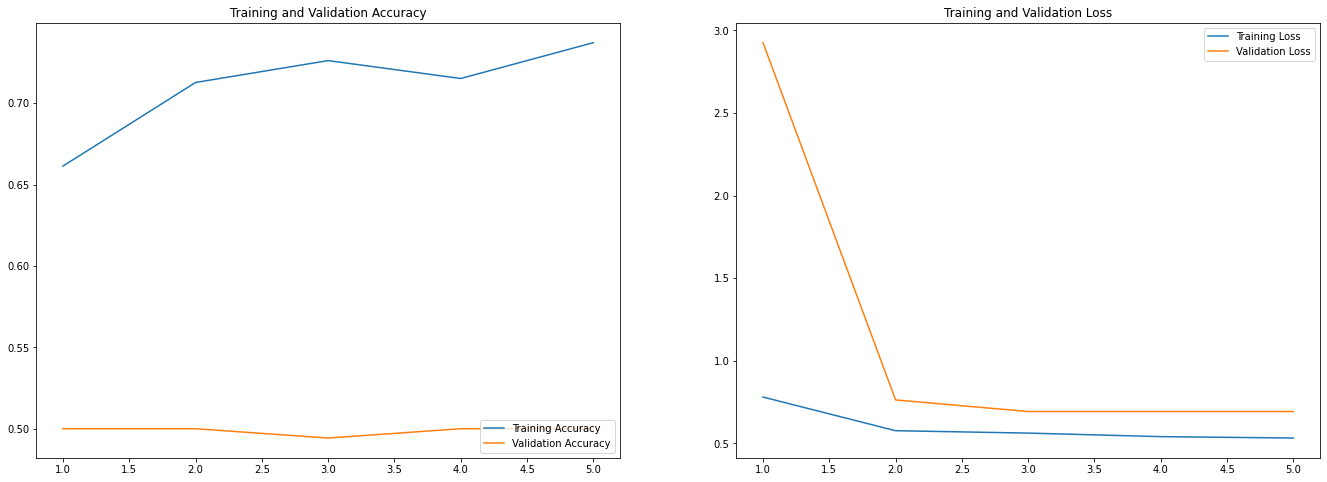

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#9. Zapisanie modelu w tensorflow.js

In [ ]:
#tfjs.converters.save_keras_model(model_ResNet50, tfjs_target_dir)
# serialize model to JSON
model_json = model_ResNet50.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")